<a href="https://colab.research.google.com/github/cfong32/data6100-proj2/blob/master/data6100_proj2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I. Executive Summary

In this project, we are trying to predict the whether the passenger was transported to another dimension by applying and comparing two different methods, logistic regression and discriment analysis. By changing all the numerical variables into new bernoulli categorial variable, we get the most efficient set of variables. Finally, we fitted a simple logistic regression model with score 0.74421 and a bernouli naive bayes model with score 0.74584.

# II. Ethics Discussion

Because the background of this data is completely fictitious, and the significance of creating this data is also for education, so this analysis and the establishment of the model will not have too many practical ethical issues. But if we imagine ourselves living in the same context, then in essence the data will leak some privacy issues. Moreover, in the face of disasters, the probability of survival of people should be equal, instead of judging whether a person can survive based on whether they are VIPs or not.

# III. Exploratory Data Analysis

In [13]:
# Upload "spaceship-titanic.zip"
from google.colab import files
from zipfile import ZipFile

uploaded = files.upload()
with ZipFile('spaceship-titanic.zip') as z:
    z.extractall()

Saving spaceship-titanic.zip to spaceship-titanic (1).zip


In [27]:
###
# Import packages
###

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.min_rows', 4)

In [28]:
###
# Read train dataset and test dataset and merge them with labeled as 'train' and 'test'
###

def read_whole_dataset():
    df_train = pd.read_csv('train.csv')
    df_test  = pd.read_csv('test.csv')
    df = pd.concat([df_train.assign(dataset='train'),
                    df_test.assign(dataset='test')])
    return df
    
df = read_whole_dataset()
display(df)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,dataset
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,train
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN,test
4276,9277_01,Earth,True,G/1498/S,PSO J318.5-22,43.0,False,0.0,0.0,0.0,0.0,0.0,Lilace Leonzaley,NaN,test


## Numerical Features

By creating summary table and histogram of each numerical variables, we find that only 'Age' looks like a normal distribution. All the other five variables more look like a right-skewed distribution. So we thought that change right-skewed variables to bernoulli variable will be more efficient to fit classification model. Also, we find out for these numerical variables have zero value rate greater than 60, which has significance evidence to validate our thoughts. 

So in the next part, we are going to create 'zeroRoomService', 'zeroFoodCourt', 'zeroShoppingMall', 'zeroSpa', and 'zeroVRDeck' to determine whether the person spent money on services or not, like roomservice, foodcourt, spa, and so on.

Basic statistics:


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,12700.000000,12707.000000,12681.000000,12664.000000,12686.000000,12702.000000
mean,28.771969,222.897852,451.961675,174.906033,308.476904,306.789482
std,14.387261,647.596664,1584.370747,590.558690,1130.279641,1180.097223
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,49.000000,77.000000,29.000000,57.000000,42.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000



Histograms:


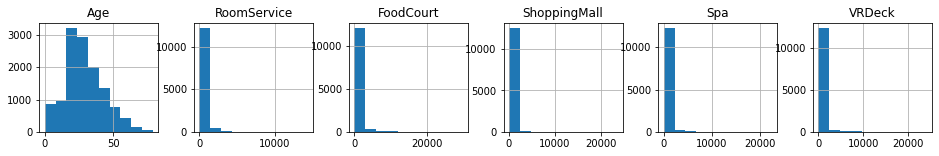


Number of zeros found in each column:


Age             0.020046
RoomService     0.640170
FoodCourt       0.628065
ShoppingMall    0.642328
Spa             0.611796
VRDeck          0.636237
dtype: float64

In [29]:
###
# Look for characteristics of the numercial features
###

cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

## Show basic stats
print('Basic statistics:')
display(df[cols].describe())

## Plot normal histograms
print()
print('Histograms:')
fig, axes = plt.subplots(1,6, figsize=(16,2))
for i, col in enumerate(cols):
    df[[col]].hist(
        ax=axes.flat[i],
    )
plt.show()

## Count how many of zeros are there
print()
print('Number of zeros found in each column:')
(df[cols] == 0).sum() / len(df)

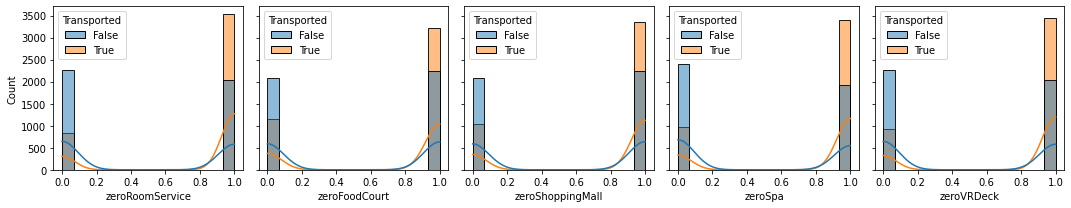

In [30]:
###
# Look into those columns of expenditures
# See how "zero expenditure" relates to 'Transported'
###

# Add columns 'zeroRoomService', 'zeroFoodCourt', ...
cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
for col in cols:
    df[f'zero{col}'] = (df[col] == 0).astype(float)

# Plot 'zeroXXX' vs 'Transported'
cols = ['zeroRoomService', 'zeroFoodCourt', 'zeroShoppingMall', 'zeroSpa', 'zeroVRDeck']
fig, axes = plt.subplots(1,5, figsize=(15,3), sharey=True)

for col, ax in zip(cols, axes.flat):
    sns.histplot(
        data=df[df.dataset=='train'],
        x=col,
        hue='Transported',
        kde=True,
        ax=ax
    )
plt.tight_layout()
plt.show()

## Categorical Features

For the categorical features, there is one special called 'Cabin'. We noticed that this variable actually provide information about the deck, number, and side of where the passengers are staying. We though that only deck and side are high correlated to the 'Transported', so we created two new variables called 'Cabin_deck' and 'Cabin_side'. After that, we changed all the categorical variables into dummy variables for further model fitting.

# IV. Data Preprocessing

In [31]:
###
# Read the whole dataset (train + test) again
###

df = read_whole_dataset()
display(df)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,dataset
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,train
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN,test
4276,9277_01,Earth,True,G/1498/S,PSO J318.5-22,43.0,False,0.0,0.0,0.0,0.0,0.0,Lilace Leonzaley,NaN,test


In [32]:
###
# Data preprocessing
###

cols_to_fillna_with_median = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
cols_to_check_zero = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
cols_to_get_dummies = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Cabin_deck', 'Cabin_side']
cols_to_float = ['Transported']

# Add extra columns indicating if the values are zero or not
for col in cols_to_check_zero:
    df[f'zero{col}'] = (df[col] == 0).astype(float)

# Make columns for "Cabin_deck" and "Cabin_side"
df['Cabin_deck'] = df.Cabin.str.split('/').map(lambda x: x[0] if isinstance(x, list) else np.NaN)
df['Cabin_side'] = df.Cabin.str.split('/').map(lambda x: x[2] if isinstance(x, list) else np.NaN)

# Fillna with median values
for col in cols_to_fillna_with_median:
    df[col].fillna(df[col].median(), inplace=True)

# Convert categorical columns into dummy variables
df = pd.concat([df.drop(columns=cols_to_get_dummies),
                pd.get_dummies(df[cols_to_get_dummies])],
               axis=1)

# Convert some columns into float
df[cols_to_float] = df[cols_to_float].astype(float)

# print the preprocessed dataframe
display(df)

,PassengerId,Cabin,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,...,Cabin_deck_A,Cabin_deck_B,Cabin_deck_C,Cabin_deck_D,Cabin_deck_E,Cabin_deck_F,Cabin_deck_G,Cabin_deck_T,Cabin_side_P,Cabin_side_S
0,0001_01,B/0/P,39.0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0.0,...,0,1,0,0,0,0,0,0,1,0
1,0002_01,F/0/S,24.0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1.0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4275,9273_01,D/297/P,27.0,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN,...,0,0,0,1,0,0,0,0,1,0
4276,9277_01,G/1498/S,43.0,0.0,0.0,0.0,0.0,0.0,Lilace Leonzaley,NaN,...,0,0,0,0,0,0,1,0,0,1


In [33]:
###
# Choose input features
# Prepare X and y
###

# Input features, X
cols_X = [
    ## Set 1 (20 dummy variables)
    'Cabin_deck_A', 'Cabin_deck_B', 'Cabin_deck_C', 'Cabin_deck_D',
    'Cabin_deck_E', 'Cabin_deck_F', 'Cabin_deck_G', 'Cabin_deck_T',
    'Cabin_side_P', 'Cabin_side_S',
    'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars',
    'CryoSleep_False', 'CryoSleep_True',
    'Destination_55 Cancri e', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e',
    'VIP_False', 'VIP_True',

    ## Set 2 (additional 5 'zeroXXX' boolean variables)
    'zeroRoomService',
    'zeroFoodCourt',
    'zeroShoppingMall',
    'zeroSpa',
    'zeroVRDeck',
    
    ## Set 3 (additional 6 numerical variables)
    # 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
]

# Output target, y
col_y = 'Transported'

# Make sure there is no NA
train_set = df.dataset=='train'                     # select only the training set
assert df[train_set][cols_X].notna().all().all()
assert df[train_set][col_y].notna().all().all()

# Standardize X and y
sr_mean_X, sr_std_X = df[cols_X].mean(), df[cols_X].std()
X_train = ((df[train_set][cols_X] - sr_mean_X) / sr_std_X).values
y_train = df[train_set][col_y].values

X_train.shape, y_train.shape

((8693, 25), (8693,))

# V. Logistic Regression

In [42]:
###
# Logistic Regression
###

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=0)
scores = cross_val_score(model, X_train, y_train, cv=5)

print('5-fold cross-validation accuracies:')
list(scores)
print(np.mean(scores))

5-fold cross-validation accuracies:
0.7387551275781817


# VI. Discriminant Analysis

In [35]:
###
# Bernoulli Naive Bayes
###

from sklearn.naive_bayes import BernoulliNB
NBmodel = BernoulliNB()
NBscores = cross_val_score(NBmodel, X_train, y_train, cv=5)

print('5-fold cross-validation accuracies:')
list(NBscores)
print(np.mean(NBscores))

5-fold cross-validation accuracies:
0.7376075558946552


# VII. Interpretations and Comparsions

## Interpretations of logistic regression

In [49]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
#from sklearn.metrics import classification_report

X, X_test, y, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=0)
model.fit(X, y)
y_predict = model.predict(X_test)
print(type(y_predict))

confusion_matrix = confusion_matrix(y_test, y_predict)
print(confusion_matrix)

<class 'numpy.ndarray'>
[[1022  281]
 [ 387  918]]


## Interpretations of bernoulli naive bayes model

In [50]:
NBmodel.fit(X, y)
y_predictNB = NBmodel.predict(X_test)

print(type(y_predictNB))


confusion_matrix_NB = confusion_matrix(y_test, y_predictNB)
#print(confusion_matrix_NB)

<class 'numpy.ndarray'>


TypeError: ignored

# VIII. Output for Kaggle Submission

In [23]:
###
# Train a new logistic regression model with all training data
# to predict on test data
###

# Training
model = LogisticRegression(random_state=0)
model.fit(X_train, y_train)

# Predict on test set
test_set = df.dataset=='test'
X_test = ((df[test_set][cols_X] - sr_mean_X) / sr_std_X).values
y_hat = model.predict(X_test)

X_test.shape, y_hat.shape

((4277, 25), (4277,))

In [24]:
###
# Train a new naive bayes model with all training data
# to predict on test data
###

# Training
NBmodel = BernoulliNB()
NBmodel.fit(X_train, y_train)

# Predict on test set
test_set = df.dataset == 'test'
X_test = df[test_set][cols_X]
y_hat = NBmodel.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but BernoulliNB was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [25]:
###
# Create a table for submission
###

df_submission = pd.DataFrame({
    'PassengerId': df[test_set].PassengerId,
    'Transported': y_hat.astype(bool)
})

df_submission

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
...,...,...
4275,9273_01,True
4276,9277_01,True


In [26]:
###
# Save submission csv file
###

import pytz
from datetime import datetime, timezone

timestr = datetime.now(pytz.timezone('Canada/Eastern')).strftime("%y%m%d%H%M")

save_path = f'submission.{timestr}.csv'
df_submission.to_csv(save_path, index=False)
print('saved to', save_path)

saved to submission.2211111426.csv
